In [5]:
from scipy.integrate import odeint
from scipy.optimize import fsolve
import numpy as np
from matplotlib import pyplot as plt
import pandas
import operator
%matplotlib inline

# $Succi$

##  Mass balance

$$Xylose + CO_2 + NH_3 = X + Succinic~ acid + Acetic ~acid  + Formic~ acid  + Water$$


$$CH_2O + CO_2 + NH_3= CH_{1.896}O_{0.603}N_{0.258} + CH_{1.5}O + CH_2O + CH_2O_2 + H_2O$$

## Metabolic flux model
<img src="succi.png" width="400" />

In [6]:
"""Mass balance"""

Mass_S = np.matrix([[1,1,1    ,1,  1,1,0,0],   #C
                    [2,0,1.896,1.5,2,2,2,3],  #H
                    [1,2,0.603,1,  1,2,1,0],    #O
                    [0,0,0.258,0,  0,0,0,1],    #N   
                   [-1,0,0,    0,  0,0,0,0],       #Xylose
                    [0,0,0,    1,  0,0,0,0],        #Succinic acid
                    [0,0,0,    0,  1,0,0,0],        #Acetic acid 
                    [0,0,0,    0,  0,1,0,0],        #Formic acid
                   ])

#Average Yeast composition (C=47, N= 7.5%, H=6.5, O=31) 
# from Atkinson and Mavituna, Biochemical Engineering and biotechnology Handbook.
MM = 12.11 + 1.0078*1.896 + 16*0.603 + 14.006*0.258
MM


27.282336800000003

# Continuous fermentation

The data that has been given in Ladakis, (2018) is the steady state concentration of succinic acids, risidual glucose and by products. In order to conduct a metabolic flux analysis the production rates of these compounds need to be determined. This is done wiht the following equations:

$$\frac{dC_i}{dt}=\frac{Q}{V}(CF_i−C_i)+r_iC_X$$

At steady state this equation becomes:

$$ 0 =\frac{Q}{V}(CF_i−C_i)+r_iC_X$$

The individual rate can then be solved for with the following equation.

$$ri = \frac{Q}{C_XV}(CF_i - C_i)$$


In [7]:
DataS = pandas.read_excel('Data.xlsx',sheetname = 'SData')
# print (DataS)
DataS = np.array(DataS)
Slen = range(len(DataS))
Results = pandas.ExcelWriter('Results.xlsx')

def MBs(i): 
    "Component order = Xylose, CO2, X, SA, AA, FA, H20"
    B = np.matrix([0,0,0,0,(40 - DataS[i,1])/(150.13/5),DataS[i,2]/(118.09/4),DataS[i,3]/(60.05/2) ,DataS[i,4]/46.03]).T
    X = np.linalg.solve(Mass_S,B)
    return [X[0,0]*(150.13/5), X[1,0]*44.01, X[2,0]*MM, X[3,0]*(118.09/4), X[4,0]*(60.05/2), X[5,0]*46.03]

MB_Succi = [MBs(i) for i in Slen]
DS = list(DataS[:,0])

MB = pandas.DataFrame(columns= ["Dilution (1/h)",  "Xylose (g/l)", "$CO_2$ (g/L)","Biomass (g/l)",
                                       "Succinic (g/l)",  "Acetic (g/l)",  "Formic (g/l)"])
for i in Slen:
    MB.loc[i] = [DS[i]] + MB_Succi[i]

Xe = sum(abs((MB['Biomass (g/l)'] - DataS[:,5])/MB['Biomass (g/l)']))/Slen[-1] * 100


Balance =  MB['Xylose (g/l)']/(150.13/5) + MB['$CO_2$ (g/L)']/44.01 + (MB['Biomass (g/l)']/MM +
                 MB['Succinic (g/l)']/(118.09/4) + MB['Acetic (g/l)']/(60.05/2) + MB['Formic (g/l)']/46.03)
                                            
print ('C balance error = ',sum(Balance)/len(Balance))
print ('Biomass error = ',Xe,'%')
MB

C balance error =  -4.16333634234e-17
Biomass error =  12.317139874 %


,Dilution (1/h),Xylose (g/l),$CO_2$ (g/L),Biomass (g/l),Succinic (g/l),Acetic (g/l),Formic (g/l)
0,0.02,-38.854806,-6.568074,8.043652,24.086331,7.519863,3.780547
1,0.03,-36.768916,-6.301315,8.972723,21.035971,6.963219,4.345697
2,0.04,-35.460123,-6.175688,9.074009,19.769784,6.599193,4.569278
3,0.06,-34.601227,-6.218275,9.027901,18.503597,6.725687,5.155174
4,0.10,-33.456033,-5.788359,8.414268,18.043165,6.871992,4.478830
5,0.15,-29.529652,-5.720046,4.680004,17.928058,7.017208,4.645413
6,0.20,-26.421268,-5.459313,3.060670,16.834532,6.628184,4.641005
7,0.25,-22.617587,-4.285991,4.727327,12.000000,5.555556,3.952991


In [15]:
"""Flux model"""
S = np.matrix(pandas.read_excel('Data.xlsx',sheetname = 'Succ'))
alpha, beta = 0.105, 0.165

def rates(i):
    Cxy, Cco2, Cx, Csa, Caa, Cfa = MBs(i)
    C = [Cxy/(150.13/5), Cco2/44.01, Cx/MM, Csa/(118.09/4), Caa/(60.05/2), Cfa/46.03]
    CX = C[2]
    D = DataS[i,0]
    r = np.zeros_like(C)
    for j in range(len(C)):
        r[j] = D*C[j]/CX
        
    return r
Xerror = []
def metafluxs(i):
    r = rates(i)
    rco2 = r[0] + r[2] + r[3] + r[4] + r[5]
    D = DataS[i,0]
    specs = np.matrix([0,0,0,0,0,0,-r[0],0,D,r[3],r[4],r[5]]).T
    F =  np.linalg.solve(S,specs)
    CO2 = F[1,0]*alpha + 1/6*F[4,0] - 1/4*F[8,0] + 1/2*F[10,0]
    Xerror.append(abs((r[1] - CO2)/r[1])*100)
#     print (r[1], CO2, rco2)
#     print (-r[0], F[0,0])
#     print (r[2]- F[1,0])
#     print (r[3]- F[8,0])
#     print (r[4]- F[10,0] - F[11,0])
#     print (r[5]- 0.5*F[11,0])

    return [F[0,0],F[1,0],F[2,0],F[3,0],F[4,0],F[5,0],F[6,0],F[7,0],F[8,0],F[9,0],F[10,0],F[11,0]]

FluxS = [metafluxs(i) for i in Slen]
FS =  pandas.DataFrame(columns= ('µ (1/h)','r_xylose (cmol/cmolX/h)','r_CO_2 (cmol/cmolX/h)',
                                'r_SA (cmol/cmolX/h)', 'r_AA (cmol/cmolX/h)', 'r_FA (cmol/cmolX/h)',))


for i in Slen:
    rCO2 = FluxS[i][1]*alpha + 1/6*FluxS[i][4] - 1/4*FluxS[i][8] + 1/2*FluxS[i][10]

    Bal = FluxS[i][0] - FluxS[i][1] - FluxS[i][8] - FluxS[i][10] - FluxS[i][11] - 0.5*FluxS[i][11]
#     print (Bal, rCO2)

    FS.loc[i] = [FluxS[i][1], FluxS[i][0], rCO2, FluxS[i][8], FluxS[i][10] + FluxS[i][11], 0.5*FluxS[i][11]]

print ('CO2 error = ', sum(Xerror)/len(Xerror), '%')

CO2 error =  8.85723429563e-14 %


In [ ]:
Results = pandas.ExcelWriter('Results.xlsx')
MB.to_excel(Results, sheet_name = 'MBA_Succi')
FS.to_excel(Results, sheet_name = 'FA_Succi')

#  $Basfia$

## Mass balance

$$Xylose + CO_2 + NH_3 = X + Succinic~ acid + Acetic ~acid  + Formic~ acid + Lactic~ acid$$


$$CH_2O + CO_2 + NH_3= CH_{1.896}O_{0.603}N_{0.258} + CH_{1.5}O + CH_2O + CH_2O_2 + CH_20 $$

## Metabolic flux model

<img src="Basfia.png" width="400" />

In [16]:
"""Mass balance"""

Mass_B = np.matrix([[1,1,1,1,1,1,1,0,0],  #C
                    [2,0,1.896,1.5,2,2,2,2,3], #H
                    [1,2,0.603,1,1,2,1,1,0],   #O
                    [0,0,0,0,0,0,0,0,1],       #N
                   [-1,0,0,0,0,0,0,0,0],      #Xylose
                    [0,0,0,1,0,0,0,0,0],       #Succinic acid
                    [0,0,0,0,1,0,0,0,0],       #Acetic acid 
                    [0,0,0,0,0,1,0,0,0],       #Formic acid
                    [0,0,0,0,0,0,1,0,0],       #Lactic acid
                  ])

In [33]:
DataB = pandas.read_excel('Data.xlsx',sheetname = 'BData')
# print (DataB)
DataB = np.array(DataB)
Blen = range(len(DataB))

def MBb(i): 
    "Component order = Xylose, CO2, X, SA, AA, FA, LA, H20"
    B = np.matrix([0,0,0,0,(40 - DataS[i,1])/(150.13/5),DataS[i,2]/(118.09/4),
                   DataS[i,3]/(60.05/2) ,DataS[i,4]/46.03, DataB[i,5]/(90.08/3)]).T
    X = np.linalg.solve(Mass_B,B)
    return [X[0,0]*(150.13/5), X[1,0]*44.01, X[2,0]*MM, X[3,0]*(118.09/4), X[4,0]*(60.05/2), X[5,0]*46.03, X[6,0]*(90.08/3)]

MB_Basfia = [MBb(i) for i in Blen]
DB = list(DataB[:,0])

MB_datab = pandas.DataFrame(columns= ["Dilution (1/h)",  "Xylose (g/l)", "$CO_2$ (g/L)","Biomass (g/l)",
                                       "Succinic (g/l)",  "Acetic (g/l)",  "Formic (g/l)", 'Lactic (g/l)'])
for i in Blen:
    MB_datab.loc[i] = [DB[i]] + MB_Basfia[i]

print ("Biomass error = ",sum(abs((MB_datab['Biomass (g/l)'] - DataB[:,6])/MB_datab['Biomass (g/l)']))/Blen[-1] * 100,'%')

Balance =  MB_datab['Xylose (g/l)']/(150.13/5) + MB_datab['$CO_2$ (g/L)']/44.01+ (MB_datab['Biomass (g/l)']/MM +
                   MB_datab['Succinic (g/l)']/(118.09/4) + MB_datab['Acetic (g/l)']/(60.05/2) + 
                   MB_datab['Formic (g/l)']/46.03  + MB_datab['Lactic (g/l)']/(90.08/3))
                                            
print ('C balance error = ',sum(Balance)/len(Balance))
MB_datab

Biomass error =  56.123249061 %
C balance error =  4.4408920985e-17


,Dilution (1/h),Xylose (g/l),$CO_2$ (g/L),Biomass (g/l),Succinic (g/l),Acetic (g/l),Formic (g/l),Lactic (g/l)
0,0.02,-38.854806,-4.564521,6.220930,24.086331,7.519863,3.780547,0.639107
1,0.04,-36.768916,-4.220504,6.385464,21.035971,6.963219,4.345697,1.427838
2,0.08,-35.460123,-4.131771,6.240550,19.769784,6.599193,4.569278,1.723975
3,0.10,-34.601227,-4.140088,6.369323,18.503597,6.725687,5.155174,1.508122
4,0.15,-33.456033,-3.886438,5.810579,18.043165,6.871992,4.478830,1.567972


In [32]:
"""Flux model"""
B = np.matrix(pandas.read_excel('Data.xlsx',sheetname = 'Basf'))

B[12,1] = beta
B[0,1] = 1 + alpha

def rates(i):
    Cxy, Cco2, Cx, Csa, Caa, Cfa, Cla  = MBb(i)
    C = [Cxy/(150.13/5), Cco2/44.01, Cx/MM, Csa/(118.09/4), Caa/(60.05/2), Cfa/46.03, Cla/(90.08/3)]
    CX = C[2]
    D = DataB[i,0]
    r = np.zeros_like(C)
    for j in range(len(C)):
        r[j] = D/CX*C[j]
        
    return r

Xerror = []

def metafluxs(i):
    r = rates(i)
    rco2 = r[0] +r[2] + r[3] + r[4] + r[5] + r[6]
    D = DataB[i,0]
    specs = np.matrix([0,0,0,0,0,0,0,0,0,0,0,0,0,D,r[3],r[4],r[5],r[6],-r[0]]).T
    F =  np.linalg.solve(B,specs)
    CO2 = F[1,0]*alpha + 1/6*F[4,0] - 1/4*F[8,0] + 1/2*F[10,0] + 1/5*F[15,0] + 1/4*F[16,0]
    Xerror.append((abs(r[1] - CO2)/-r[1])*100)
#     print (r[1], CO2, rco2)
#     Xerror.append(abs((r[0] + F[0,0])/r[0])*100)
#     print (-r[0], F[0,0])
#     print (r[2]- F[1,0])
#     print (r[3]- F[18,0] -  F[16,0])
#     print (r[4]- F[14,0])
#     print (r[5]- 0.5*F[11,0])
#     print (r[6]- F[12,0])
    
    return [F[0,0],F[1,0],F[2,0],F[3,0],F[4,0],F[5,0],F[6,0],F[7,0],F[8,0],F[9,0],
            F[10,0],F[11,0],F[12,0],F[13,0],F[14,0],F[15,0],F[16,0],F[17,0],F[18,0]]

FluxB = [metafluxs(i) for i in Blen]
FB =  pandas.DataFrame(columns= ('µ (1/h)','r_xylose (cmol/cmolX/h)','r_CO_2 (cmol/cmolX/h)',
                                'r_SA (cmol/cmolX/h)', 'r_AA (cmol/cmolX/h)', 'r_FA (cmol/cmolX/h)','r_LA (cmol/cmolX/h)'))


for i in Blen:
    rCO2 = FluxB[i][1]*alpha + 1/6*FluxB[i][4] - 1/4*FluxB[i][8] + 1/2*FluxB[i][10] + 1/5*FluxB[i][15] + 1/4*FluxB[i][16]
    Bal = FluxB[i][0] - FluxB[i][1] - FluxB[i][16] - FluxB[i][18] - FluxB[i][14] - 0.5*FluxB[i][11] - FluxB[i][12]
#     print (Bal,rCO2)
    FB.loc[i] = [FluxB[i][1], FluxB[i][0], rCO2, FluxB[i][16] + FluxB[i][18], FluxB[i][14], 0.5*FluxB[i][11], FluxB[i][12]]

print ('CO2 Error = ', sum (Xerror)/len(Xerror), '%')
FB

-3.46944695195e-18
-6.93889390391e-18
1.38777878078e-17
2.77555756156e-17
4.16333634234e-17
CO2 Error =  2.37446344935e-13 %


,µ (1/h),r_xylose (cmol/cmolX/h),r_CO_2 (cmol/cmolX/h),r_SA (cmol/cmolX/h),r_AA (cmol/cmolX/h),r_FA (cmol/cmolX/h),r_LA (cmol/cmolX/h)
0,0.02,0.113502,-0.009097,0.071561,0.021968,0.007204,0.001867
1,0.04,0.209282,-0.016389,0.121775,0.039635,0.016135,0.008127
2,0.08,0.413039,-0.032835,0.234206,0.076870,0.034718,0.020080
3,0.10,0.493608,-0.040295,0.268467,0.095949,0.047972,0.021514
4,0.15,0.784748,-0.062195,0.430440,0.161196,0.068529,0.036778


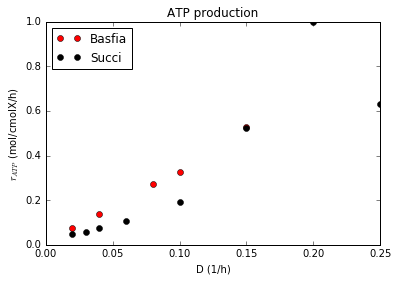

In [36]:
rATPS = []
v6_v4s = []
rATPB = []
v6_v4b = []
for i in Slen:
    rATPS.append(-1/5*FluxS[i][2] + 1/3*FluxS[i][7] + 1/3*FluxS[i][9] + 1/2*FluxS[i][10] + 1/2*FluxS[i][11] + 5/12*FluxS[i][8]) 
    v6_v4s.append(FluxS[i][6]/FluxS[i][4])
for i in Blen:
    rATPB.append(-1/5*FluxB[i][2] + 1/3*FluxB[i][7] + 1/3*FluxB[i][9] + 1/2*FluxB[i][14] + 
                 1/4*FluxB[i][8] + 1/4*FluxB[i][16] + 1/6*FluxB[i][18]) 
    v6_v4b.append(FluxB[i][6]/FluxB[i][4])
    
plt.figure('ATP')
plt.title('ATP production')
plt.plot(DB,rATPB,'ro', label = 'Basfia')
plt.plot(DS,rATPS,'ko',label = 'Succi')
plt.ylabel('$r_{ATP}$ (mol/cmolX/h)')
plt.xlabel('D (1/h)')
plt.legend(loc = 'best')
plt.show()

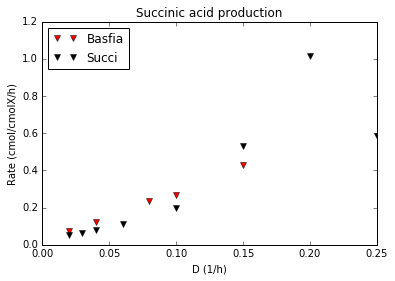

In [27]:
plt.figure('Cycle')
plt.title('Succinic acid production')
plt.plot(FB['µ (1/h)'],FB['r_SA (cmol/cmolX/h)'],'rv', label = "Basfia")
plt.plot(FS['µ (1/h)'],FS['r_SA (cmol/cmolX/h)'],'kv',label = "Succi")
plt.ylabel('Rate (cmol/cmolX/h)')
plt.xlabel('D (1/h)')
plt.legend(loc = 'best')
plt.show()

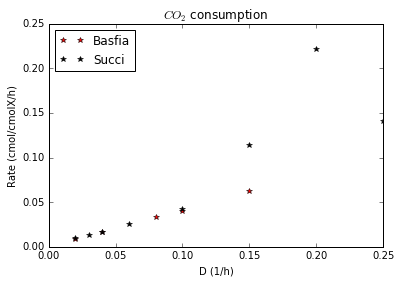

In [28]:
plt.figure('Cycle')
plt.title('$CO_2$ consumption')
plt.plot(FB['µ (1/h)'],-FB['r_CO_2 (cmol/cmolX/h)'],'r*', label = "Basfia")
plt.plot(FS['µ (1/h)'],-FS['r_CO_2 (cmol/cmolX/h)'], 'k*',label = "Succi")
plt.ylabel('Rate (cmol/cmolX/h)')
plt.xlabel('D (1/h)')
plt.legend(loc = 'best')
plt.show()

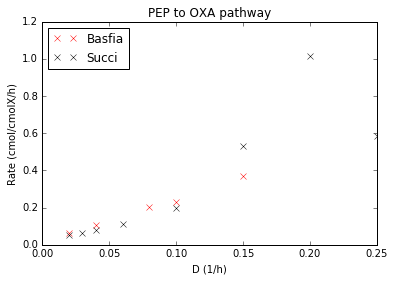

In [29]:
Sv8 = [FluxS[i][8] for i in Slen]
Bv8 = [FluxB[i][8] for i in Blen]

plt.figure('Cycle')
plt.title('PEP to OXA pathway')
plt.plot(FB['µ (1/h)'],Bv8,'rx', label = "Basfia")
plt.plot(FS['µ (1/h)'],Sv8,'kx',label = "Succi")
plt.ylabel('Rate (cmol/cmolX/h)')
plt.xlabel('D (1/h)')
plt.legend(loc = 'best')
plt.show()

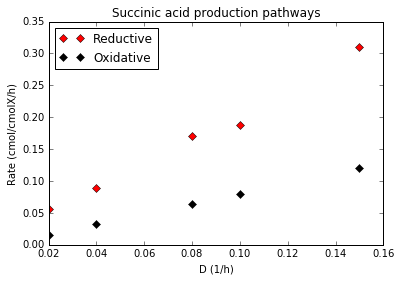

In [30]:
Bv18 = [FluxB[i][18] for i in Blen]
Bv16 = [FluxB[i][16] for i in Blen]

plt.figure('Cycle')
plt.title('Succinic acid production pathways')
plt.plot(FB['µ (1/h)'],Bv18,'rD', label = "Reductive")
plt.plot(FB['µ (1/h)'],Bv16,'kD',label = "Oxidative")
plt.ylabel('Rate (cmol/cmolX/h)')
plt.xlabel('D (1/h)')
plt.legend(loc = 'best')
plt.show()

In [34]:
FB

,µ (1/h),r_xylose (cmol/cmolX/h),r_CO_2 (cmol/cmolX/h),r_SA (cmol/cmolX/h),r_AA (cmol/cmolX/h),r_FA (cmol/cmolX/h),r_LA (cmol/cmolX/h)
0,0.02,0.113502,-0.009097,0.071561,0.021968,0.007204,0.001867
1,0.04,0.209282,-0.016389,0.121775,0.039635,0.016135,0.008127
2,0.08,0.413039,-0.032835,0.234206,0.076870,0.034718,0.020080
3,0.10,0.493608,-0.040295,0.268467,0.095949,0.047972,0.021514
4,0.15,0.784748,-0.062195,0.430440,0.161196,0.068529,0.036778


In [35]:
FS

,µ (1/h),r_xylose (cmol/cmolX/h),r_CO_2 (cmol/cmolX/h),r_SA (cmol/cmolX/h),r_AA (cmol/cmolX/h),r_FA (cmol/cmolX/h)
0,0.02,0.087782,-0.010124,0.055345,0.016990,0.005571
1,0.03,0.111702,-0.013060,0.064996,0.021155,0.008612
2,0.04,0.142032,-0.016876,0.080536,0.026433,0.011938
3,0.06,0.208949,-0.025619,0.113645,0.040616,0.020307
4,0.10,0.361279,-0.042645,0.198164,0.074210,0.031549
5,0.15,0.859978,-0.113651,0.531015,0.204366,0.088249
6,0.20,1.568741,-0.221147,1.016583,0.393556,0.179749
7,0.25,1.086813,-0.140510,0.586454,0.266963,0.123906
